## Bearing Failure Anomaly Detection

(This notebook has been adapted from infusedIdeas' notebook: https://github.com/infusedIdeas/ai_software_dev/blob/master/AI/APIs/Sensor%20Anomaly%20Detection%20-%20Streaming%20Model/Sensor%20Anomaly%20Detection%20-%20Streaming%20Model.ipynb)

In this workbook, we use an autoencoder neural network to identify accelerometric anomalies from sensor readings from smart neck collars for cattle. The goal is to be able to predict future estrus periods before they happen. The accelerometric sensor readings are from prototype IoT devices mounted on cows. 

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

C:\Users\Tanzim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# set random seed
seed(10)
set_random_seed(10)

# Data loading and pre-processing

In [3]:
# Read in the csv file exported from Django backend into a dataframe
data = pd.read_csv("new_format_data_cowdy.csv", sep=',', header=0)

In [4]:
from Functions import pre_process_data

In [5]:
df = pre_process_data(data)

In [6]:
from Functions import remove_duplicates

In [7]:
# subset for one animal
df = df[df['device_id']=='262B']

In [8]:
df = remove_duplicates(df)

In [9]:
# drop column device_id
df = df.drop(columns = ['device_id'])

In [10]:
 #convert time column from str to datetime type
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by=['time'])

In [11]:
# set time as index of dataframe
df = df.set_index('time')

In [12]:
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (12432, 3)


,x,y,z
time,,,
2019-11-14 23:59:30,0.027344,0.000000,0.968750
2019-11-14 23:59:31,0.019531,0.000000,0.957031
2019-11-14 23:59:33,0.027344,-0.007812,0.957031
2019-11-14 23:59:34,0.027344,-0.007812,0.957031
2019-11-14 23:59:35,0.027344,-0.007812,0.968750


In [13]:
len(df)

12432

In [14]:
0.80 * len(df)

9945.6

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the anomalous behavior.

In [15]:
train = df.iloc[0:9946, :]
test = df.iloc[9947:12432, :]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (9946, 3)
Test dataset shape: (2485, 3)


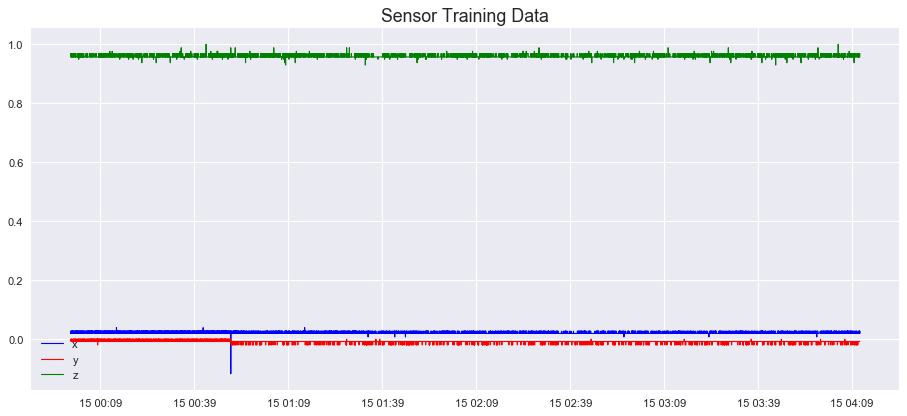

In [16]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['x'], label='x', color='blue', animated = True, linewidth=1)
ax.plot(train['y'], label='y', color='red', animated = True, linewidth=1)
ax.plot(train['z'], label='z', color='green', animated = True, linewidth=1)
#ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Data', fontsize=16)
plt.show()

Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [17]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

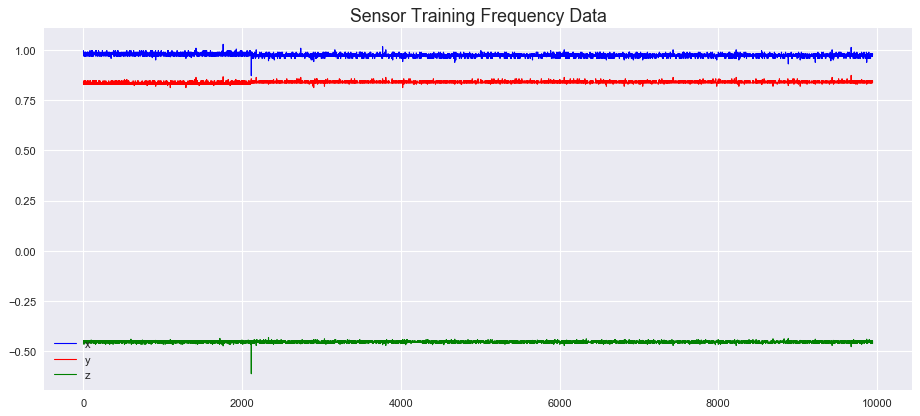

In [18]:
# frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='x', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='y', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='z', color='green', animated = True, linewidth=1)
#ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Training Frequency Data', fontsize=16)
plt.show()

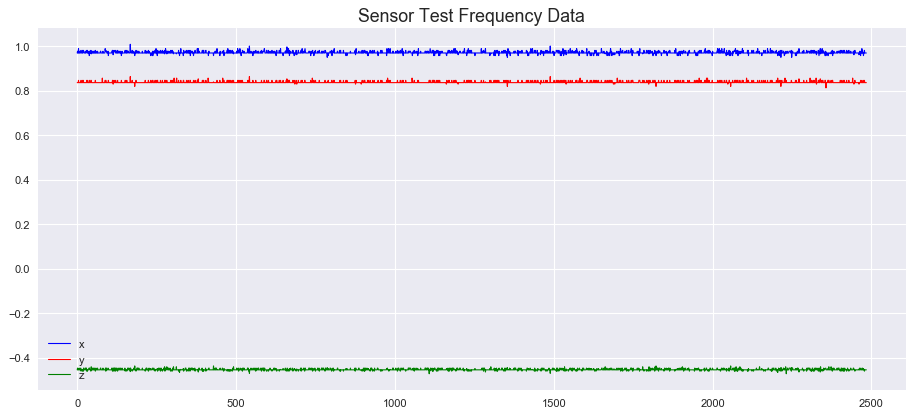

In [19]:
# frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='x', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='y', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='z', color='green', animated = True, linewidth=1)
#ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Sensor Test Frequency Data', fontsize=16)
plt.show()

In [20]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [21]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (9946, 1, 3)
Test data shape: (2485, 1, 3)


In [22]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [23]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 3)              51        
Total para

In [24]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 9448 samples, validate on 498 samples
Epoch 1/100
9448/9448 [==============================] - 17s 2ms/step - loss: 0.1133 - val_loss: 0.0259
Epoch 2/100
9448/9448 [==============================] - 6s 606us/step - loss: 0.0341 - val_loss: 0.0259
Epoch 3/100
9448/9448 [==============================] - 6s 605us/step - loss: 0.0339 - val_loss: 0.0250
Epoch 4/100
9448/9448 [==============================] - 6s 643us/step - loss: 0.0336 - val_loss: 0.0248
Epoch 5/100
9448/9448 [==============================] - 6s 585us/step - loss: 0.0335 - val_loss: 0.0244
Epoch 6/100
9448/9448 [==============================] - 6s 598us/step - loss: 0.0331 - val_loss: 0.0241
Epoch 7/100
9448/9448 [==============================] - 6s 613us/step - loss: 0.0330 - val_loss: 0.0255
Epoch 8/100
9448/9448 [==============================] - 6s 614us/step - loss: 0.0328 - val_loss: 0.0241
Epoch 9/100
9448/9448 [==============================] - 6s 662us/step - loss: 0.0328 - val_loss: 0.0245
Epoch 10/

Epoch 78/100
9448/9448 [==============================] - 5s 579us/step - loss: 0.0127 - val_loss: 0.0122
Epoch 79/100
9448/9448 [==============================] - 6s 641us/step - loss: 0.0126 - val_loss: 0.0128
Epoch 80/100
9448/9448 [==============================] - 6s 622us/step - loss: 0.0127 - val_loss: 0.0123
Epoch 81/100
9448/9448 [==============================] - 6s 595us/step - loss: 0.0126 - val_loss: 0.0129
Epoch 82/100
9448/9448 [==============================] - 6s 592us/step - loss: 0.0126 - val_loss: 0.0120
Epoch 83/100
9448/9448 [==============================] - 6s 657us/step - loss: 0.0126 - val_loss: 0.0121
Epoch 84/100
9448/9448 [==============================] - 6s 647us/step - loss: 0.0126 - val_loss: 0.0123
Epoch 85/100
9448/9448 [==============================] - 6s 617us/step - loss: 0.0126 - val_loss: 0.0124
Epoch 86/100
9448/9448 [==============================] - 6s 659us/step - loss: 0.0125 - val_loss: 0.0124
Epoch 87/100
9448/9448 [======================

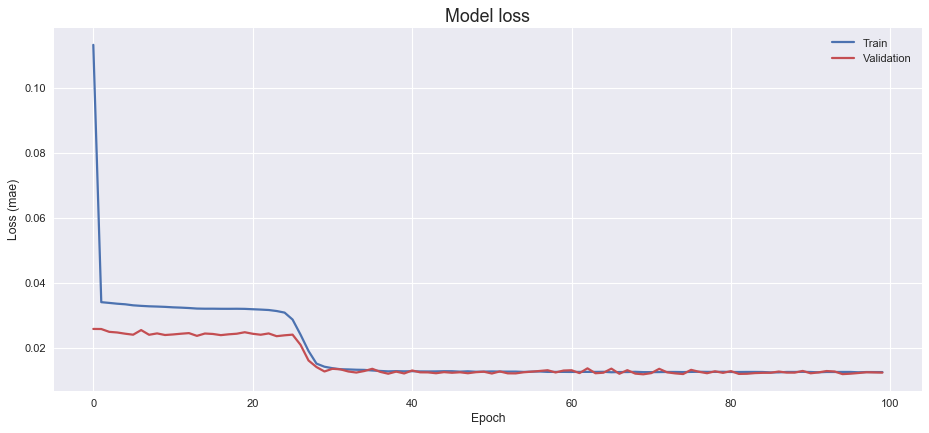

In [25]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

C:\Users\Tanzim\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0.0, 0.5)

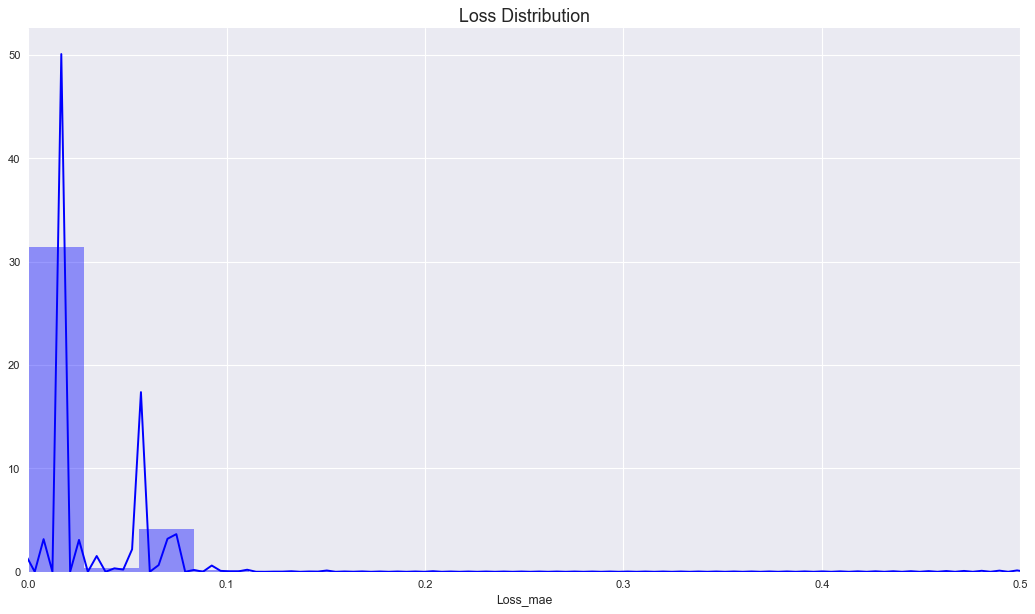

In [26]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.5 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [27]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.5
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
time,,,
2019-11-15 04:11:31,0.000759,0.5,False
2019-11-15 04:11:32,0.016968,0.5,False
2019-11-15 04:11:33,0.000759,0.5,False
2019-11-15 04:11:35,0.000759,0.5,False
2019-11-15 04:11:36,0.072372,0.5,False


In [28]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.5
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

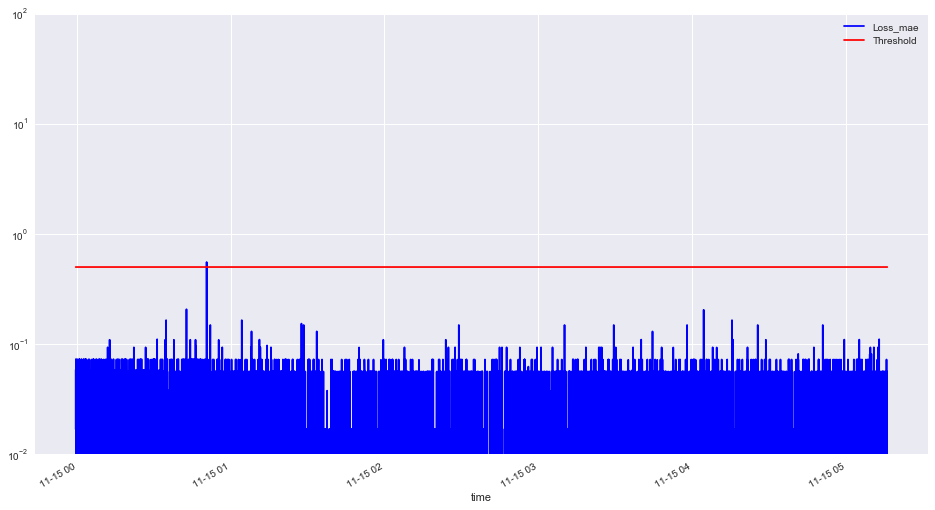

In [29]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming estrus behavior well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal conditions.

In [30]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
